In [5]:
# import libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Effects of imbalanced class
---

In [6]:
# Adjust weights to make the dataset imbalanced
random_state = 42 # choose between 42 or 69
X, y = make_classification(n_samples=1000, n_features=2, 
                    n_informative=2, n_redundant=0, n_repeated=0, n_classes=2,
                    n_clusters_per_class=2, weights=[0.9, 0.1], # 90% of class 0, 10% of class 1
                    flip_y=0.01, class_sep=1.5, hypercube=True, 
                    shift=0.0, scale=1.0, shuffle=True, random_state=random_state)

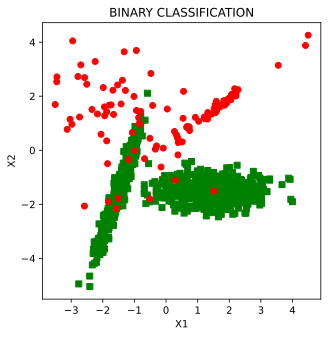

In [7]:
# convert to a pytorch tensor
data = torch.tensor(X).float()
labels = torch.tensor(y).float()
labels = labels.view(-1, 1)

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'gs')
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ro')
plt.title('BINARY CLASSIFICATION')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

In [8]:
# a function that creates the ANN model

def model():
    # model architecture
    ann = nn.Sequential(
      nn.Linear(2,1),   # input layer
      nn.ReLU(),        # activation unit
      nn.Linear(1,1),   # output unit
        )

    # loss function
    lossfunc = nn.BCEWithLogitsLoss()

    # optimizer
    optim = torch.optim.SGD(ann.parameters(),lr=.01)

    # model output
    return ann,lossfunc,optim

In [17]:
# train the model

# global parameter
epochs = 200

def train(trainProp):

    # initialize losses
    losses = torch.zeros(epochs)
    train_accuracy = []
    test_accuracy  = []

    # loop over epochs
    for i in range(epochs):

        # separate train from test data
        # Note 1: unique split for each epoch!
        # Note 2: here we specify the training size, not the testing size!
        X_train,X_test, y_train,y_test = train_test_split(data,labels, train_size=trainProp, random_state=None, shuffle=True, stratify=None)


        # forward pass and loss
        pred_train = ann(X_train)
        loss = lossfunc(pred_train,y_train)

        # backprop
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        pred_train_proba = torch.sigmoid(pred_train).detach()

        # convert probabilities to binary predictions (0 or 1) based on threshold of 0.5
        pred_train_labels = (pred_train_proba >= 0.5).float()

        # compute accuracy for train set
        train_accuracy.append(100 * torch.mean((pred_train_labels == y_train).float()).item())

        # get predicted probabilities for the test set and convert to binary predictions
        pred_test_proba = torch.sigmoid(ann(X_test)).detach()
        pred_test_labels = (pred_test_proba >= 0.5).float()

        # compute accuracy for test set
        test_accuracy.append(100 * torch.mean((pred_test_labels == y_test).float()).item())

    # function output
    return train_accuracy,test_accuracy


# Test the model by running it once

In [18]:
# create a model
ann,lossfunc,optim = model()

# train the model
# NOTE: the input is the training proportion, not the test proportion!
train_accuracy,test_accuracy = train(.8)


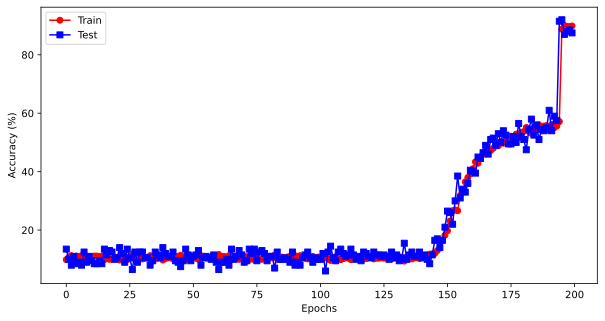

In [19]:
# plot the results
fig = plt.figure(figsize=(10,5))

plt.plot(train_accuracy,'ro-')
plt.plot(test_accuracy,'bs-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train','Test'])
plt.show()

# What happened here?
---
Look at the graph of the data.


Important: Test accuracy should not exceed training accuracy, as the model is specifically optimized for the training data. Possible reasons for this behavior include:

1. The test dataset may differ from the training dataset. It’s crucial to perform a proper train/test split, ensuring both sets come from the same underlying distribution. It’s likely that the test data used was from a completely different, potentially easier, dataset.

2. Excessive regularization was applied. However, even with high regularization, the test and training data distributions would need to differ for this result to occur.

# Now for the experiment

In [20]:
trainSetSizes = np.linspace(.2,.95,10)

alltrain_accuracy = np.zeros((len(trainSetSizes),epochs))
alltest_accuracy = np.zeros((len(trainSetSizes),epochs))

for i in range(len(trainSetSizes)):

    # create a model
    ann,lossfunc,optim = model()

    # train the model
    train_accuracy,test_accuracy = train(trainSetSizes[i])

    # store the results
    alltrain_accuracy[i,:] = train_accuracy
    alltest_accuracy[i,:] = test_accuracy

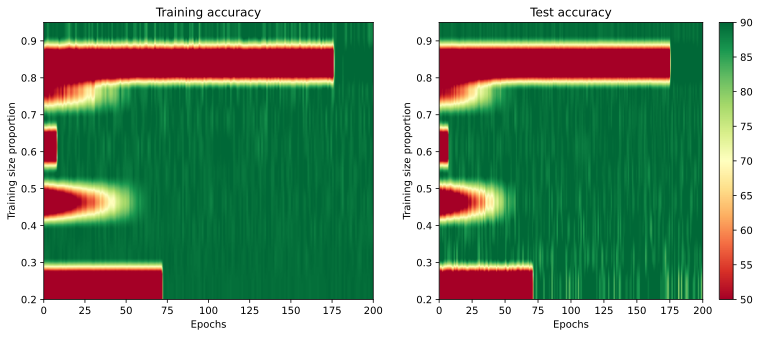

In [21]:
fig,ax = plt.subplots(1,2,figsize=(13,5))

# First plot with red-to-green spectrum
ax[0].imshow(alltrain_accuracy, aspect='auto', vmin=50, vmax=90, 
             extent=[0, epochs, trainSetSizes[0], trainSetSizes[-1]], cmap='RdYlGn')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Training size proportion')
ax[0].set_title('Training accuracy')

# Second plot with red-to-green spectrum
p = ax[1].imshow(alltest_accuracy, aspect='auto', vmin=50, vmax=90, 
                 extent=[0, epochs, trainSetSizes[0], trainSetSizes[-1]], cmap='RdYlGn')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training size proportion')
ax[1].set_title('Test accuracy')

# Adding a colorbar
fig.colorbar(p, ax=ax[1])

plt.show()

# Experiments

1. Redo the experiment but this time stratify the train-test split in terms of the y values. Compare the result to the original, provide an explaination.

2. Redo the experiment but this time try to set seed (any number) the experiment without stratification. Compare the result to the original, provide an explaination.

3. Redo the experiment but this time try to set seed (any number) the experiment with stratification. Compare the result to the original, provide an explaination.

4. Try to improve the model by adding more layers, and changing the value of the learning rate. Creat a bubblechart with the x-axis as the epochs, y-axis as the learning rate, the size of the bubble as the layers, and the color as the accuracy.

5. Try changing the random state of the make_classifier function to generate a slightly different dataset, run the original code, then perform the experiments.

6. However, did you know that the entire experiment is flawed? Why should we not use accuracy as a metric for imbalanced data? If so what would be the best metric for imbalanced class given no preprocessing step has been done to address the class imbalance?